# Train the `KNeighborsClassifier` on the dataset.

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [3]:
data = pd.read_csv('forest_dataset (1).csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,...,0,0,0,0,0,0,0,0,0,2


In [4]:
labels = data[data.columns[-1]].values
feature_matrix = data[data.columns[:-1]].values
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(feature_matrix, labels, test_size = 0.2, random_state = 42)

Учим без параметров:

In [5]:
clf = KNeighborsClassifier()
clf.fit(train_feature_matrix, train_labels)
clf_pred = clf.predict(test_feature_matrix)
clf_accuracy = accuracy_score(test_labels, clf_pred)

print(f"Точность kNN без параметров: {clf_accuracy:.4f}")

Точность kNN без параметров: 0.7365


GridSearc-им параметры:

In [12]:
params = {
    'n_neighbors': range(1, 10),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance']
}

clf_grid = GridSearchCV(KNeighborsClassifier(), params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(train_feature_matrix, train_labels)

print("Лучшие параметры kNN:")
print(clf_grid.best_params_)

optimal_clf = clf_grid.best_estimator_
optimal_clf_pred = optimal_clf.predict(test_feature_matrix)
optimal_clf_accuracy = accuracy_score(test_labels, optimal_clf_pred)

print(f"\nТочность kNN с лучшими параметрами: {optimal_clf_accuracy:.4f}")

Лучшие параметры kNN:
{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

Точность kNN с лучшими параметрами: 0.7845


Вероятности принадлежности к классам для тестовой выборки:

In [14]:
pred_prob = optimal_clf.predict_proba(test_feature_matrix)

Визуализация:

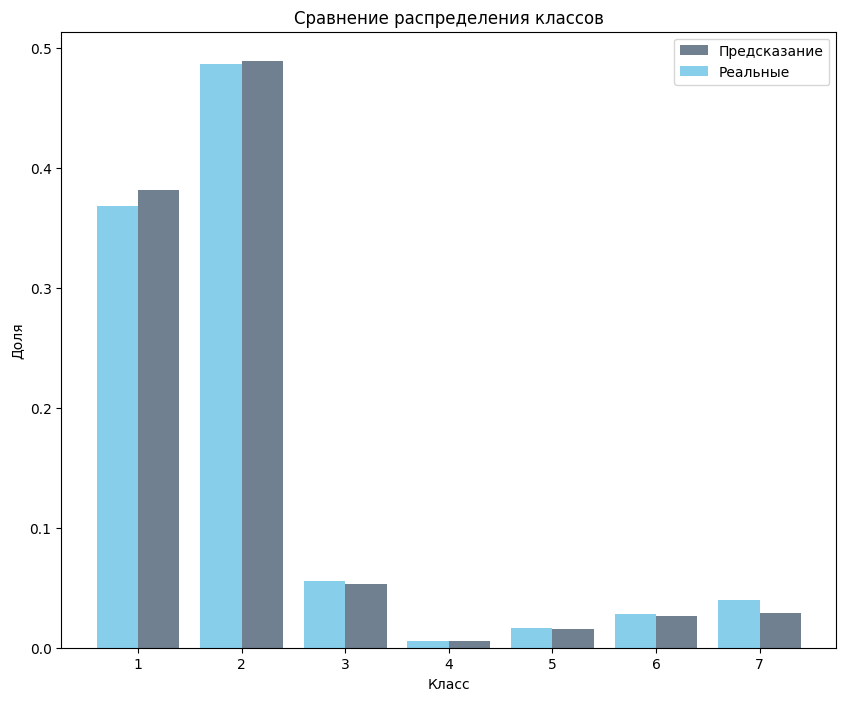

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))
pred_freq = pred_prob.mean(axis=0)

plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='Предсказание', color='slategray')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='Реальные', color='skyblue')
plt.title('Сравнение распределения классов')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.legend()
plt.show()

## Выводы

Там в конклюжн надо было сравнить с логистической регрессией:

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [22]:
scaler = StandardScaler()
train_feature_matrix_scaled = scaler.fit_transform(train_feature_matrix)
test_feature_matrix_scaled = scaler.transform(test_feature_matrix)

log_reg = LogisticRegression(max_iter=1000, random_state=42, solver='saga', n_jobs=-1)
log_reg.fit(train_feature_matrix_scaled, train_labels)
log_reg_pred = log_reg.predict(test_feature_matrix_scaled)
log_reg_accuracy = accuracy_score(test_labels, log_reg_pred)

print(f"Точность логистической регрессии: {log_reg_accuracy:.4f}")

Точность логистической регрессии: 0.7180


In [26]:
if optimal_clf_accuracy > log_reg_accuracy:
    print("KNN классифицирует тестовую выборку лучше логистической регрессии.")
else:
    print("KNN классифицирует тестовую выборку хуже логистической регрессии.")

KNN классифицирует тестовую выборку лучше логистической регрессии.


Ну раз knn классифицирует лучше, значит и сама модель knn лучше чем модель логистической регрессии)) На самом деле knn во-первых чувствителен к выбросам, во-вторых медленный и плохо работает на больших выборках или большом количестве признаков. Преимущество knn перед линейной регрессией в том, что knn справляется сильно лучше, когда у нас граница между классами не линейная, а хотя бы чуть более сложная.

ROC-кривая

In [39]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

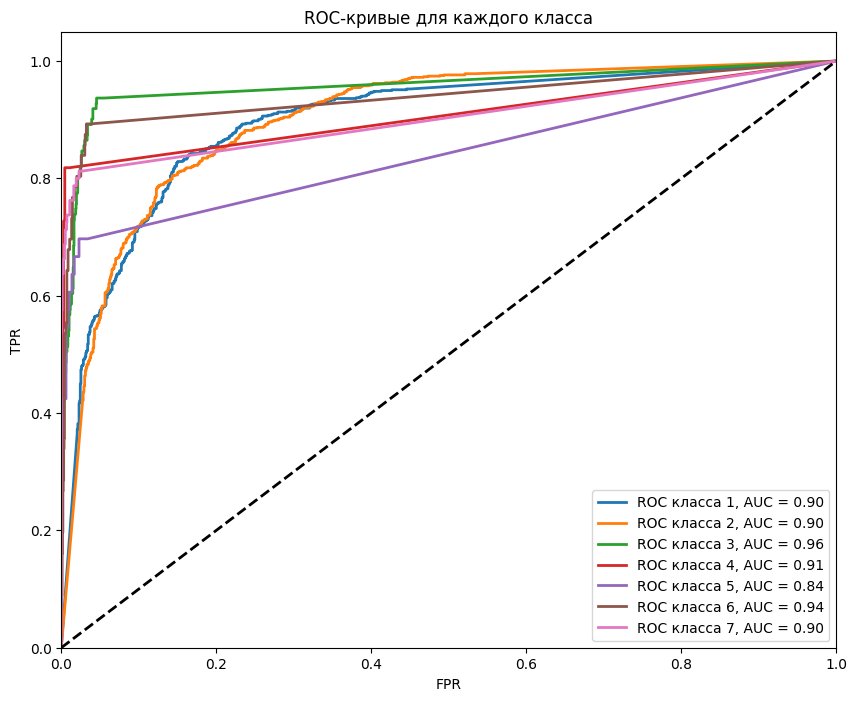

In [42]:
test_labels_bin = label_binarize(test_labels, classes=np.unique(train_labels))
n_classes = test_labels_bin.shape[1]
y_score = optimal_clf.predict_proba(test_feature_matrix)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC класса {0}, AUC = {1:0.2f}'.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривые для каждого класса')
plt.legend(loc="lower right")
plt.show()